In [52]:
# Basic libraries
import pandas as pd
import numpy as np
import sklearn

# Model libraries
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

# Evaluation libraries
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score

# Plot
import matplotlib.pyplot as plt

In [3]:
path_to_csv = '/Users/gabrielle/Desktop/machine-learning-zoomcamp/03-classification/homework/bank-full.csv'
df = pd.read_csv(path_to_csv, sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
columns = ['age','job','marital','education','balance',
'housing','contact','day','month','duration','campaign','pdays','previous','poutcome']

In [6]:
df['y'] = (df['y'] == 'yes').astype(int)

In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [35]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

In [11]:
len(df), len(df_full_train), len(df_train), len(df_val), len(df_test)

(45211, 36168, 27126, 9042, 9043)

In [30]:
df_sort = df[['previous', 'y']].sort_values(by='previous')

In [91]:
roc_auc_score(y_train, df_train.balance)

0.5888313805382317

In [93]:
roc_auc_score(y_train, df_train.day)

0.474042117616092

In [94]:
roc_auc_score(y_train, df_train.duration)

0.8147002759670778

In [95]:
roc_auc_score(y_train, df_train.previous)

0.5985653242764153

In [105]:
def train(df, y, C):
    dicts = df[columns].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y)

    return model, dv

In [39]:
def predict(model, dv, df):
    dicts = df[columns].to_dict(orient='records')
    X = dv.transform(dicts)

    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred

In [40]:
model, dv = train(df_train, y_train)
y_pred = predict(model, dv, df_val)

In [42]:
roc_auc_score(y_val, y_pred)

0.9002650841867572

In [76]:
threshold = np.arange(0, 1.01, 0.01)
metrics_column = ['threshold','tp','fp','tn','fn','precision','recall', 'f1']
scores = []
for t in threshold:
    
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()

    precision = tp / (tp + fp) if (tp + fp)!= 0 else 0
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    scores.append([t, tp, fp, tn, fn, precision, recall, f1])

df_metrics = pd.DataFrame(scores, columns = metrics_column)
df_metrics
# print(t, precision, recall)
# plt.plot(t, precision)
# plt.plot(t, recall)

/var/folders/z7/8f0d81rd03s5mm4pjv0xdyvm0000gn/T/ipykernel_11505/2499462080.py:13: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)


,threshold,tp,fp,tn,fn,precision,recall,f1
0,0.00,1098,7944,0,0,0.121433,1.000000,0.216568
1,0.01,1094,6970,974,4,0.135665,0.996357,0.238812
2,0.02,1093,5770,2174,5,0.159260,0.995446,0.274589
3,0.03,1087,4718,3226,11,0.187252,0.989982,0.314936
4,0.04,1066,3785,4159,32,0.219749,0.970856,0.358380
...,...,...,...,...,...,...,...,...
96,0.96,31,17,7927,1067,0.645833,0.028233,0.054101
97,0.97,25,15,7929,1073,0.625000,0.022769,0.043937
98,0.98,21,10,7934,1077,0.677419,0.019126,0.037201
99,0.99,11,6,7938,1087,0.647059,0.010018,0.019731


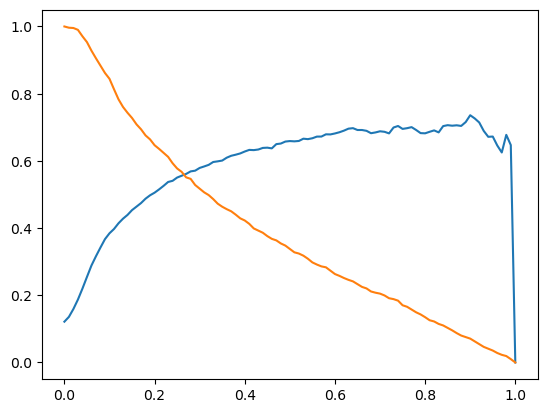

In [77]:
plt.plot(df_metrics.threshold, df_metrics.precision)
plt.plot(df_metrics.threshold, df_metrics.recall)


In [89]:
df_metrics[['threshold','f1']].sort_values(by='f1',ascending=False)

,threshold,f1
23,0.23,0.572158
22,0.22,0.570596
21,0.21,0.569099
19,0.19,0.568865
20,0.20,0.567319
...,...,...
96,0.96,0.054101
97,0.97,0.043937
98,0.98,0.037201
99,0.99,0.019731


In [106]:
for C in [0.000001, 0.001, 1]:
    scores = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.y.values
        y_val = df_val.y.values
        
        model, dv = train(df_train, y_train, C=C)
        y_pred = predict(model, dv, df_val)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print(C, round(np.mean(scores),3), round(np.std(scores),3))

1e-06 0.701 0.009
0.001 0.861 0.007
1 0.906 0.006


In [101]:
round(np.mean(scores),3), round(np.std(scores),3)

(0.906, 0.006)